# Problem: Predicting Airplane Delays

The multi-fold goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model
- Move from a simple model to an ensemble model
- Hyperparameter optimization
- Check feature importance

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

## About this dataset
This dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1% of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018.

### Features
For more information about features in the dataset, see [On-time delay dataset features](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

### Dataset attributions  
Website: https://www.transtats.bts.gov/

Dataset(s) used in this lab were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available at https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=Mode_ID=1&Mode_Desc=Aviation&Subject_ID2=0.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### 1. Determine if and why ML is an appropriate solution to deploy.

In [ ]:
# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.

In [ ]:
# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.

In [ ]:
# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.

In [ ]:
# Write your answer here

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

In [2]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [3]:
# Check whether the file is already in the desired path or if it needs to be downloaded

base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'
file_path = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['mkdir', '-p', csv_base_path])
    subprocess.run(['aws', 's3', 'cp', 
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/csvFlightData-5/', 
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

File already downloaded!


In [4]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

#### Extract CSV files from ZIP files

In [5]:
def zip2csv(zipFile_name , file_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays'):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """
    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_8.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_7.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_11.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Tim

In [6]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [7]:
from IPython.display import IFrame

IFrame(src="./data/csvFlightDelays/readme.html", width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [8]:
df_temp = pd.read_csv('./data/csvFlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')# **ENTER YOUR CODE HERE**

**Question**: Print the row and column length in the dataset, and print the column names.

**Hint**: Use the `<dataframe>.shape` function to view the rows and columns of a dataframe and `<dataframe>.columns` to view the column names.

In [9]:
df_shape = df_temp.shape# **ENTER YOUR CODE HERE**
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

**Hint**: Use the built-in Pandas function `head(x)` to print `x` number of rows.

In [10]:
# Enter your code here
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [11]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:# **ENTER YOUR CODE HERE**
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [12]:
# Enter your code here
[del_col for del_col in df_temp.columns if 'Del' in del_col]

['DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'DivArrDelay']

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [13]:
df_temp.shape[0]

585749

In [14]:
df_temp.Year.unique()

array([2018])

In [15]:
print("The years in this dataset are: ", df_temp.Year.unique())

The years in this dataset are:  [2018]


In [16]:
df_temp.Month.unique()

array([9])

In [17]:
min(df_temp.FlightDate)

'2018-09-01'

In [18]:
df_temp.Reporting_Airline.unique()

array(['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA',
       'F9', 'G4', 'MQ', 'NK', 'OH', 'OO'], dtype=object)

In [19]:
df_temp.Origin.unique()

array(['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU',
       'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST',
       'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA',
       'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL',
       'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA',
       'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO',
       'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR',
       'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA',
       'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF',
       'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE',
       'SRQ', 'MLI', 'BHM', 'IAD', 'CSG', 'CMH', 'MCO', 'MBS', 'FLL',
       'SDF', 'TPA', 'MVY', 'LAS', 'LGB', 'SFO', 'SAN', 'LAX', 'RNO',
       'PDX', 'ANC', 'ABQ', 'SLC', 'DEN', 'PHX', 'OAK', 'SMF', 'SJU',
       'SEA', 'HOU', 'STX', 'BUR', 'SWF', 'SJC', 'DAB', 'BQN', 'PSE',
       'ORH', 'HYA',

In [20]:
df_temp.Dest.unique()

array(['CVG', 'PWM', 'RDU', 'MSP', 'MSN', 'SHV', 'CLT', 'PIT', 'RIC',
       'IAH', 'ATL', 'JFK', 'DCA', 'DTW', 'LGA', 'TYS', 'PVD', 'FNT',
       'LIT', 'BUF', 'ORD', 'TRI', 'IND', 'BGR', 'AVP', 'BWI', 'LEX',
       'BDL', 'GRR', 'CWA', 'TUL', 'MEM', 'AGS', 'EWR', 'MGM', 'PHL',
       'SYR', 'OMA', 'STL', 'TVC', 'ORF', 'CLE', 'ABY', 'BOS', 'OAJ',
       'TLH', 'BTR', 'SAT', 'JAX', 'BNA', 'CHO', 'VLD', 'ROC', 'DFW',
       'GNV', 'ACK', 'PBI', 'CHS', 'GRB', 'MOT', 'MKE', 'DSM', 'ILM',
       'GSO', 'MCI', 'SBN', 'BTV', 'MVY', 'XNA', 'RST', 'EVV', 'HPN',
       'RSW', 'MDT', 'ROA', 'GSP', 'MCO', 'CSG', 'SAV', 'PHF', 'ALB',
       'CHA', 'ABE', 'BMI', 'MSY', 'IAD', 'GTR', 'CID', 'CAK', 'ATW',
       'AUS', 'BQK', 'MLI', 'CAE', 'CMH', 'AVL', 'MBS', 'FLL', 'SDF',
       'TPA', 'LNK', 'SRQ', 'MHT', 'BHM', 'LAS', 'SFO', 'SAN', 'RNO',
       'LGB', 'ANC', 'PDX', 'SJU', 'ABQ', 'SLC', 'DEN', 'LAX', 'PHX',
       'OAK', 'SMF', 'SEA', 'STX', 'BUR', 'DAB', 'SJC', 'SWF', 'HOU',
       'BQN', 'PSE',

In [21]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp.Year.unique())
print("The months covered in this dataset are: ", df_temp.Month.unique())
print("The date range for data is :" , min(df_temp.FlightDate), " to ", max(df_temp.FlightDate))
print("The airlines covered in this dataset are: ", list(df_temp.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(df_temp.Origin.unique()))
print("The Destination airports covered are: ", list(df_temp.Dest.unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [22]:
df_temp['Origin'].value_counts()

ATL    31525
ORD    28257
DFW    22802
DEN    19807
CLT    19655
       ...  
HGR        8
OGD        8
PPG        8
STC        5
HYA        4
Name: Origin, Length: 346, dtype: int64

In [23]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [24]:
counts.sort_values(by='Origin',ascending=False).head(15 )# Enter your code here

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

In [ ]:
# Enter your answer here
# ArrDel15 and DepDel15 can help on that

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [25]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name = 'data/combined_files.csv'):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    df = pd.DataFrame()# Enter your code here 
    
    for file in csv_files:
        # Read the CSV file into a dataframe
        df_temp = pd.read_csv(file)# Enter your code here
        
        # Filter the columns based on the filter_cols variable
        # e.g. columns = ['col1', 'col2']
        # df_filter = df[columns]
        df_temp = df_temp[filter_cols]# Enter your code here
        
        # Keep only the subset_vals in each of the subset_cols
        # HINT: Use the `isin` function to check if the val is in dataframe column
        # and then choose the rows that include it
        # e.g. df[df['col1'].isin('5')]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)] # Enter your code here     
        
        # Use Pandas concatenate `pd.concat` to concatenate the main dataframe with the dataframe for each file
        df = pd.concat([df, df_temp], axis=0)
    
        
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [26]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [27]:
start = time.time()
combine_csv(csv_files, cols, subset_cols, subset_vals)
print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at data/combined_files.csv
csv's merged in 4.86 minutes


#### Load dataset

Load the combined dataset.

In [28]:
data = pd.read_csv('data/combined_files.csv')# Enter your code here to read the combined csv file.

Print the first 5 records.

In [29]:
# Enter your code here 
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2016,1,3,2,3,2016-03-02,UA,IAH,TX,ORD,IL,2134,0.0,0.0,925.0,4,-21.0,0.0,0.0,115.0
1,2016,1,3,2,3,2016-03-02,UA,IAH,TX,ORD,IL,1445,0.0,0.0,925.0,4,-16.0,0.0,0.0,117.0
2,2016,1,3,2,3,2016-03-02,UA,IAH,TX,LAX,CA,1932,0.0,0.0,1379.0,6,-19.0,0.0,0.0,187.0
3,2016,1,3,2,3,2016-03-02,UA,PHX,AZ,IAH,TX,1440,0.0,0.0,1009.0,5,-2.0,0.0,0.0,124.0
4,2016,1,3,2,3,2016-03-02,UA,IAH,TX,PHX,AZ,1530,0.0,0.0,1009.0,5,-23.0,0.0,0.0,142.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [31]:
data.shape[1]

20

In [34]:
data.Year.unique()

array([2016, 2018, 2015, 2017, 2014])

In [37]:
data.Month.unique()

array([ 3,  8, 10,  9,  7,  5, 12,  1, 11,  2,  6,  4])

In [39]:
data.FlightDate

0          2016-03-02
1          2016-03-02
2          2016-03-02
3          2016-03-02
4          2016-03-02
              ...    
1658125    2018-02-11
1658126    2018-02-11
1658127    2018-02-11
1658128    2018-02-11
1658129    2018-02-11
Name: FlightDate, Length: 1658130, dtype: object

In [43]:
data.Reporting_Airline.unique()

array(['UA', 'WN', 'AA', 'DL', 'OO'], dtype=object)

In [44]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(data.Month.unique())))
print("The date range for data is :" , min(data.FlightDate), " to ", max(data.FlightDate))
print("The airlines covered in this dataset are: ", list(data.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(data.Origin.unique()))
print("The Destination airports covered are: ", list(data.Dest.unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2016, 2018, 2015, 2017, 2014]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['UA', 'WN', 'AA', 'DL', 'OO']
The Origin airports covered are:  ['IAH', 'PHX', 'LAX', 'DEN', 'SFO', 'ORD', 'DFW', 'ATL', 'CLT']
The Destination airports covered are:  ['ORD', 'LAX', 'IAH', 'PHX', 'SFO', 'ATL', 'DEN', 'DFW', 'CLT']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [48]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) # Enter your code here

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [55]:
# Enter your code here
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [57]:
### Remove null columns
data = data[~data.is_delay.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [61]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

Before jumping to modeling, it is always a good practice to look at feature distribution, correlations, etc.
- This will give an idea of any non-linearity/patterns in the data.
    - Linear models: Add power/exponential/interaction features
    - Try a non-linear model
- Data imbalance 
    - Choose metrics that will not give biased model performance (accuracy. vs AUC)
    - Use weighted/custom loss functions
- Missing data
    - Do imputation based on simple statistics - mean, median, mode (numerical variables) frequent class (categorical variables)
    - Clustering based imputation (KNNs to predict column value)
    - Drop column

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

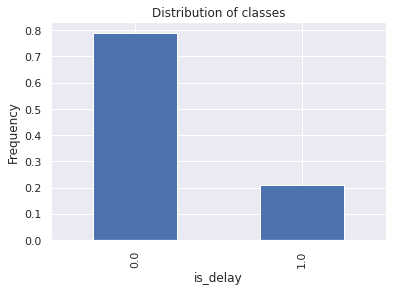

In [64]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

In [ ]:
# Enter your answer here

# delay is 25%

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

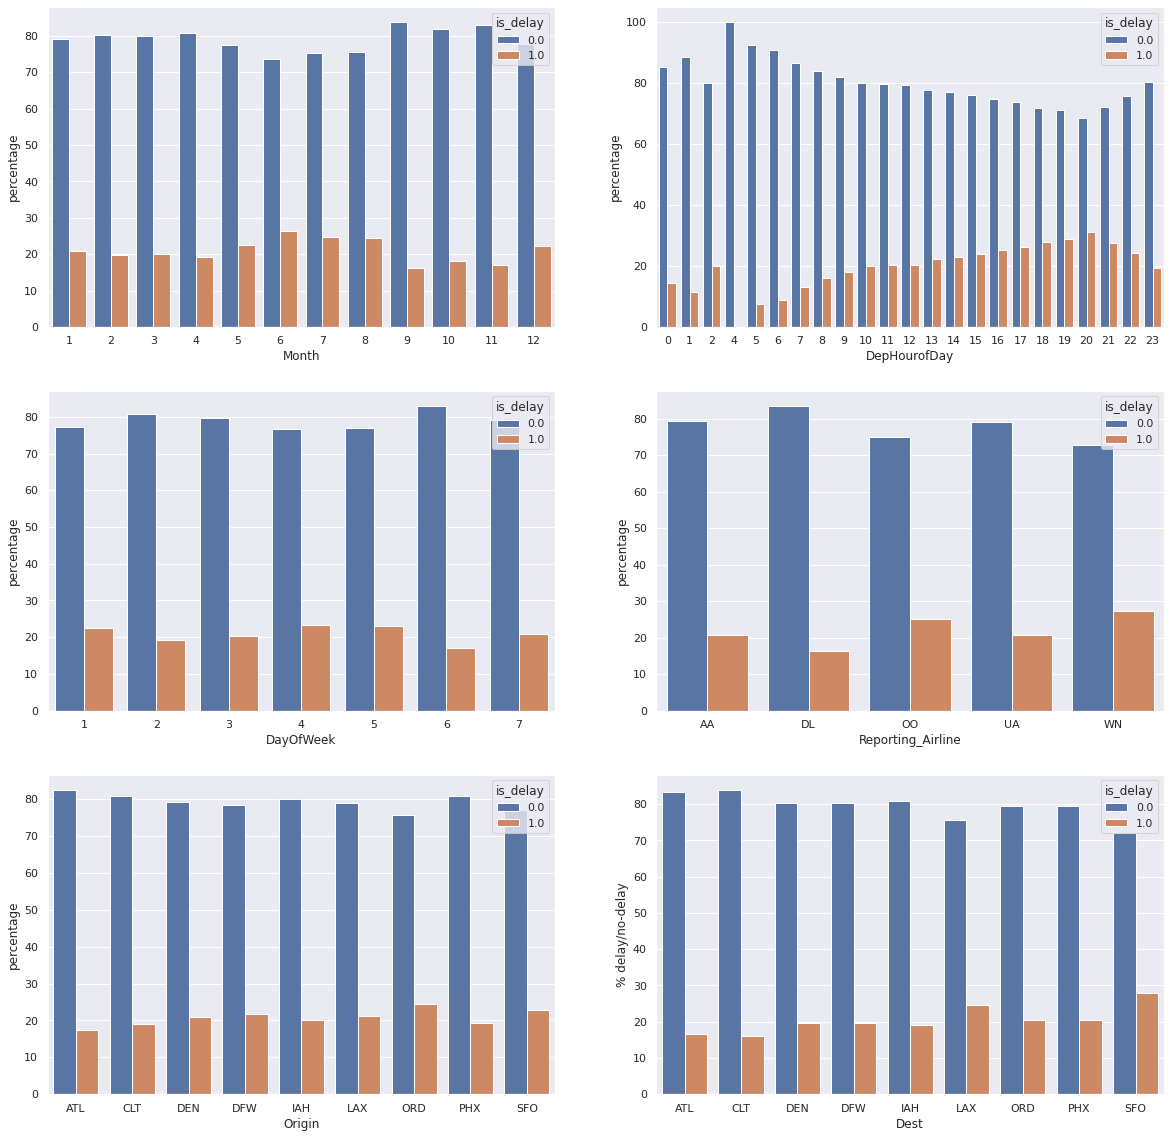

In [65]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

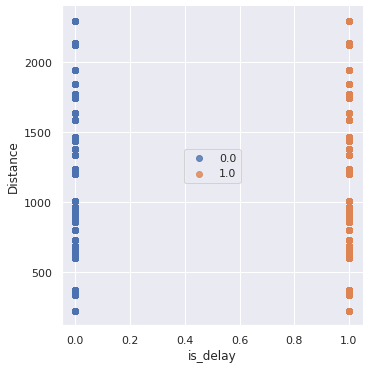

In [66]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Enter your answers here

#  % delay is high in May, June, July, August and December.
#  % delays are higher at night than during the day. There are no flights departing at 3AM!
#  Sunday(1), Wednesday(4), Saturday(7) have relatively higher delays than other days.
#  Airline WN has the highest % delays compared to others.
#  Flights with SFO as a destination have higher delays than others.
#  Flights with ORD as a origin have higher delays than others.

### Features

Look at all the columns and what their specific types are.

In [67]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [68]:
data_orig = data.copy()
data = data[[ 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay', 'is_delay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay', 'is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [71]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [72]:
# Enter your code here
len(data)

1635590

In [73]:
# Enter your code here

data.columns

Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [74]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [75]:
data

,Distance,target,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23,is_delay_1.0
0,925.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,925.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1379.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1009.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1009.0,0.0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658125,1744.0,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1658126,925.0,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1658127,337.0,1.0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1658128,888.0,1.0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## <span style="color:red"> End of Lab 2 </span>

Save the project file to your local computer. Follow these steps:

1. At the top of the page, click the **File** menu. 

1. Select **Download as**, and click **Notebook(.ipynb)**.  

This downloads the current notebook to the default download folder on your computer.

# Step 3: Model training and evaluation

There are some preliminary steps that you must include when converting the dataset from a dataframe to a format that a machine learning algorithm can use. For Amazon SageMaker, here are the steps you need to take:

1. Split the data into `train_data`, `validation_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).  
3. Upload the data to your Amazon S3 bucket. If you have not created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).  

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Take note of the key decisions you've made in this phase in your project presentation.</span>

### Train test split

In [79]:
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data['target']).astype("float32") # Enter your code here
    
    # Drop all the unwanted columns including the target column
    drop_list = ['target']# Enter your code here
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")# Enter your code here
    
    np.random.seed(0)

    # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    # Example: train_test_split(x, y, test_size=0.3)
    train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)# Enter your code here
    
    # Use the sklearn function again to split the test dataset into 50% validation and 50% test
    val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)# Enter your code here
    
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels

In [81]:
# Use the function to create your datasets
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(data)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (1308472, 94)
Length of train_labels is: (1308472,)
Length of val_features is: (163559, 94)
Length of val_labels is: (163559,)
Length of test_features is: (163559, 94)
Length of test_labels is: (163559,)


**Sample answer**
```
Length of train_features is: (1308472, 71)
Length of train_labels is: (1308472,)
Length of val_features is: (163559, 71)
Length of val_labels is: (163559,)
Length of test_features is: (163559, 71)
Length of test_labels is: (163559,)
```

### Baseline classification model

In [82]:
import sagemaker
from sagemaker.predictor import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

num_classes = len(pd.unique(train_labels)) # Enter your code here

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria='cross_entropy_loss')

### Sample Code
```
num_classes = len(pd.unique(train_labels))
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                             binary_classifier_model_selection_criteria = 'cross_entropy_loss')
                                              
```

Linear learner accepts training data in protobuf or CSV content types, and accepts inference requests in protobuf, CSV, or JSON content types. Training data has features and ground-truth labels, while the data in an inference request has only features.

In a production pipeline, it is recommended to convert the data to the Amazon SageMaker protobuf format and store it in Amazon S3. However, to get up and running quickly, AWS provides the convenient method `record_set` for converting and uploading when the dataset is small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so let's use it here. The `RecordSet` object will keep track of the temporary Amazon S3 location of your data. Use the `estimator.record_set` function to create train, validation, and test records. Then, use the `estimator.fit` function to start your training job.

In [83]:
### Create train, val, test records
train_records = classifier_estimator.record_set(train_features,train_labels, channel='train')# Enter your code here
val_records = classifier_estimator.record_set(val_features,val_labels, channel='validation')# Enter your code here
test_records = classifier_estimator.record_set(test_features,test_labels, channel='test')# Enter your code here

Now, train your model on the dataset that you just uplaoded.

### Sample code
```
linear.fit([train_records,val_records,test_records])
```

In [84]:
### Fit the classifier
# Enter your code here

classifier_estimator.fit([train_records, val_records, test_records])

2022-11-10 10:38:05 Starting - Starting the training job...ProfilerReport-1668076684: InProgress
...
2022-11-10 10:38:49 Starting - Preparing the instances for training.........
2022-11-10 10:40:32 Downloading - Downloading input data.........
2022-11-10 10:41:58 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/10/2022 10:42:00 INFO 140517880678208] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '

## Model evaluation
In this section, you'll evaluate your trained model. First, use the `estimator.deploy` function with `initial_instance_count= 1` and `instance_type= 'ml.m4.xlarge'` to deploy your model on Amazon SageMaker.

In [85]:
### Deloy an endpoint for batch prediction
classifier_predictor = classifier_estimator.deploy(initial_instance_count=1, 
                                                   instance_type='ml.m4.xlarge') # Enter your code here

--------!

Once your endpoint is 'InService', evaluate how your model performs on the test set. Use the `predict_batches` function to predict the metrics on your test set.

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

def predict_batches(predictor, features, labels):
    """
    Return evaluation results
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    """
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(features, 100)]

    # Parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    preds = preds.reshape((-1,))

    # Calculate accuracy
    accuracy = (preds == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    auc = roc_auc_score(labels, preds)
    print(f'AUC     : {auc}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, preds, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 

To view the confusion matrix, run the `predict_batches` function on your test dataset.

Accuracy: 1.0
AUC     : 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0


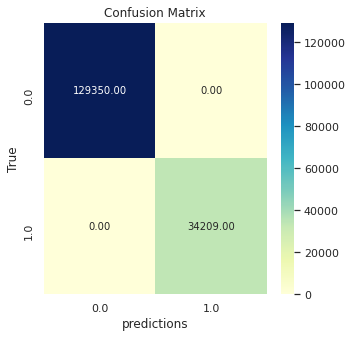

In [87]:
# Enter your code here
predict_batches(classifier_predictor, test_features, test_labels)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record answers to these and other similar questions you might answer in this section in your project presentations. Record key details and decisions you've made in your project presentations.</span>


**Question**: What can you summarize from the confusion matrix?


#### Case of class imbalance
- When dealing with imbalanced classes, it is important to weigh in between which metric you can optimize to solve a given problem at hand.  
- You can choose precision or recall, depending on whether only correct positive predictions matter or all positive predictions are of most importance.  
- You can also balance between precision and recall with custom weights with F1-beta score.  

- AUC measures the area under the TPR vs. FPR curve. It is the power of the model to discriminate between a positive and negative prediction.  
- An AUC of 0.5 means the model predictions are as good as random prediction.  
- Note that AUC is independent of threshold online precision or recall, making it easier to compare models.  

For the classifier above, we see that:
- Accuracy ~ 80% and AUC ~0.5, meaning the model does not have enough predictive power and is as good as a random choice.  
- High false negatives resulted in a low recall value.  
    
To improve classifier performance, you can:
- Add more features  
- Optimize for a different metric/loss  
- Try non-linear models  
- Do ensemble modeling  

For more information about customizing linear learner, see [Train Faster, More Flexible Models with Amazon SageMaker Linear Learner](https://aws.amazon.com/blogs/machine-learning/train-faster-more-flexible-models-with-amazon-sagemaker-linear-learner/).

## <span style="color:red"> End of Lab 3 </span>

Save the project file to your local computer. Follow these steps:

1. At the top of the page, click the **File** menu. 

1. Select **Download as**, and click **Notebook(.ipynb)**.  

This downloads the current notebook to the default download folder on your computer.

# Iteration II

# Step 4: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record key decisions and methods you use in this section in your project presentations, as well as any new performance metrics you obtain after evaluating your model again.</span>

Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
# holidays_19 = ['2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27' , '2019-07-04', '2019-09-02' ,'2019-10-14', '2019-11-11','2019-11-28', '2019-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
%%bash

aws s3 cp s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay', 'is_delay', 'is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday','is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

Create the training sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate the LinearLearner estimator object
num_classes = # Enter your code here
classifier_estimator = # Enter your code here

### Sample code

```
num_classes = len(pd.unique(train_labels)) 
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')
```

In [ ]:
train_records = classifier_estimator.record_set(train_features, train_labels, channel='train')
val_records = classifier_estimator.record_set(val_features, val_labels, channel='validation')
test_records = classifier_estimator.record_set(test_features, test_labels, channel='test')

classifier_estimator.fit([train_records, val_records, test_records])

In [ ]:
classifier_predictor = # Enter your code here

In [ ]:
predict_batches(classifier_predictor, test_features, test_labels)

The linear model shows only a little improvement in performance. Try a tree-based ensemble model called XGBoost with Amazon SageMaker.

### Try the XGBoost model

Here are the steps you need to take:  

1. Use the training set variables and save them as CSV files: train.csv, validation.csv and test.csv  
2. Store the bucket name in the variable. The Amazon S3 bucket name is provided to the left of the lab instructions.  
a. `bucket = <LabBucketName>`  
b. `prefix = 'sagemaker/xgboost'`  
3. Use Boto3 to upload the model to the bucket.    

In [ ]:
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9*len(data))])  

pd.concat([train_data['target'], train_data.drop(['target'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['target'], validation_data.drop(['target'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['target'], test_data.drop(['target'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [ ]:
# Enter your code here to define bucket and prefix
bucket = <LabBucketName> # Enter your code here
prefix = 'sagemaker/xgboost'

In [ ]:
### Upload data to S3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [ ]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('xgboost',boto3.Session().region_name, '0.90-1')

Use the `sagemaker.s3_input` function to create a record_set for the training and validation datasets.

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Deploy the predictor for your new model and evaluate the model on the test dataset.

In [ ]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(initial_instance_count = <CODE>, 
                           instance_type = <CODE>,
                          serializer=CSVSerializer())# Enter your code here

In [ ]:
test_data = pd.concat([test_data['target'], test_data.drop(['target'], axis=1)], axis=1)

In [ ]:
def predict(predictor , features, labels , prob_threshold = 0.5, rows=500):
    """
    Return evaluation results
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    prob_threshold : Probability cut off to separate positive and negative class
    """
    split_array = np.array_split(features, int(features.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    preds = np.fromstring(predictions[1:], sep=',')
    preds = preds.reshape((-1,))
    predictions = np.where(preds > prob_threshold , 1, 0)
    labels = labels.reshape((-1,))
    
    
    # Calculate accuracy
    accuracy = (predictions == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    auc = roc_auc_score(labels, preds)
    print(f'AUC     : {auc}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 
    return list(preds)

In [ ]:
predictions = predict(xgb_predictor, test_data.values[:, 1:] ,  test_data.iloc[:, 0:1].values, prob_threshold = 0.5)

### Try different thresholds

In [ ]:
predictions = predict(xgb_predictor, test_data.values[:, 1:] ,  test_data.iloc[:, 0:1].values, prob_threshold = 0.8)

**Question**: What can you conclude from how the model did on the test set?

In [ ]:
#Enter your answer here

### Hyperparameter optimization (HPO)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 2, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        early_stopping_rounds=50,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

In [ ]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 0.5),
                        'min_child_weight': ContinuousParameter(3, 10),
                        'alpha': ContinuousParameter(0, 2)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=9,
                            max_parallel_jobs=3)

In [ ]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It may take 25-30 minutes.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, click **Amazon SageMaker**.  
1. Click **Training** > **Hyperparameter tuning jobs**.  
1. You can check the status of each hyperparametertuning job, its objective metric value, and its logs.  

In [ ]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name

# Run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']


from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")
    
### Get the hyperparameter tuning job results in a dataframe
tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()

if len(tuner_df) > 0:
    df = tuner_df[tuner_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
tuner_df

Deploy the best model from the hyperparameter optimization training.

In [ ]:
xgb_predictor_hpo = # Enter your code here. 

In [ ]:
predictions = predict(xgb_predictor_hpo, test_data.values[:, 1:] ,  test_data.iloc[:, 0:1].values, prob_threshold = 0.5)

**Question**: Try different hyperparameters and hyperparameter ranges. Does this improve the model?

### Feature importance

The model files for all hyperparameter tuning jobs are saved by the training job name as in the table above in the folder: "{bucket}/{prefix}/output/". You can load the model and use it like a regular sklearn model object for interpretation.

In [ ]:
#best_hpo_model_path = "s3://" + bucket + "/sagemaker/xgboost/output/<Best model TrainingJobName>/output/model.tar.gz"
best_hpo_model_path = <path-to-your-model>
### Download best_hpo_model_path to local
!aws s3 cp {best_hpo_model_path} .

In [ ]:
# Install xgboost
!pip install xgboost=='0.90'

#### Load picked model file

In [ ]:
import pickle
import tarfile
import xgboost

with open('model.tar.gz', 'rb') as f:
    with tarfile.open(fileobj=f, mode='r') as tar_f:
        with tar_f.extractfile('xgboost-model') as extracted_f:
            xgbooster = pickle.load(extracted_f)

#### Map column names to XGBoost model

In [ ]:
columns = list(data.columns)
columns.remove('target')

In [ ]:
feature_importance = xgbooster.get_fscore()
feature_importance_col = {}

for column, fname in zip(columns, xgbooster.feature_names):
    try:
         feature_importance_col[column] = feature_importance[fname]
    except Exception:
        pass

#### Sort by feature importance value

In [ ]:
sorted(feature_importance_col.items(), key=lambda kv: kv[1], reverse=True)

### Sample output

```
[('AWND_O', 13851),
 ('AWND_D', 13452),
 ('DepHourofDay', 13344),
 ('TAVG_O', 13106),
 ('TAVG_D', 12800),
 ('Distance', 8478),
 ('PRCP_O', 4210),
 ('PRCP_D', 3916),
 ('Reporting_Airline_UA', 1791),
 ('Year_2016', 1290),
 ('Year_2015', 1285),
 ('Year_2018', 1157),
 ('Quarter_4', 1092),
 ('Year_2017', 1009),
 ('DayOfWeek_5', 838),
 ('DayOfWeek_4', 833),
 ('Quarter_2', 799),
 ('DayOfWeek_7', 783),
 ('Reporting_Airline_WN', 736),
 ('DayOfWeek_3', 718),
 ('Origin_ORD', 706),
 ('DayOfWeek_2', 685),
 ('Reporting_Airline_DL', 663),
 ('Dest_LAX', 627),
 ('DayOfWeek_6', 614),
 ('Reporting_Airline_OO', 596),
 ('Origin_LAX', 590),
 ('Month_11', 565),
 ('Month_5', 543),
 ('Dest_ORD', 539),
 ('SNOW_O', 506),
 ('Month_8', 497),
 ('Month_12', 495),
 ('Month_7', 484),
 ('Origin_DFW', 480),
 ('Quarter_3', 477),
 ('Dest_DFW', 462),
 ('Origin_DEN', 456),
 ('Origin_SFO', 438),
 ('Month_6', 437),
 ('Dest_SFO', 437),
 ('Month_10', 422),
 ('Month_9', 407),
 ('Month_4', 394),
 ('Dest_DEN', 379),
 ('SNOW_D', 375),
 ('Month_3', 369),
 ('Dest_IAH', 369),
 ('Origin_PHX', 347),
 ('Dest_PHX', 346),
 ('Origin_IAH', 342),
 ('DayofMonth_15', 324),
 ('DayofMonth_17', 322),
 ('DayofMonth_21', 322),
 ('Origin_CLT', 322),
 ('DayofMonth_20', 316),
 ('DayofMonth_9', 313),
 ('DayofMonth_19', 307),
 ('DayofMonth_26', 303),
 ('DayofMonth_7', 301),
 ('DayofMonth_4', 300),
 ('DayofMonth_2', 299),
 ('DayofMonth_27', 298),
 ('DayofMonth_3', 294),
 ('DayofMonth_28', 287),
 ('Month_2', 284),
 ('DayofMonth_5', 284),
 ('DayofMonth_12', 282),
 ('DayofMonth_11', 276),
 ('Dest_CLT', 276),
 ('DayofMonth_6', 275),
 ('DayofMonth_22', 274),
 ('DayofMonth_8', 273),
 ('DayofMonth_18', 273),
 ('DayofMonth_29', 267),
 ('DayofMonth_23', 266),
 ('DayofMonth_14', 263),
 ('DayofMonth_30', 260),
 ('DayofMonth_10', 259),
 ('DayofMonth_16', 257),
 ('DayofMonth_24', 255),
 ('DayofMonth_13', 245),
 ('DayofMonth_25', 237),
 ('is_holiday_1', 231),
 ('DayofMonth_31', 164)]
```

Based on the feature importance above, you can see that DepHourofDay, Airwind, and Temperature at both source and destination are the major influencers in deciding the flight delay.

This is one way to validate what is intuitive in terms of features and what the model actually learns.

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset, features, and hyperparameters? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. Are there outstanding questions you have about aspects of the pipeline that just didn't make sense to you?
5. What were the three most important things you learned about machine learning while completing this project?

#### <span style="color: blue;">Project presentation: Summarize your answers to these questions in your project presentation as well. Pull together all of your notes for your project presentation at this point and prepare to present your findings to the class.</span>